---
title: The Mystery of 2019 Champions League Final
description: Exploring a strange statistic about the Liverpool starting 11 in the Champions League final 
date: 11-20-2022
categories:
  - web-scraping
  - python
  - pandas
  - matplotlib
  - data-viz
  - football
# TODO: fix lightbox error
# filters:
#   - lightbox
# lightbox:
#   match: auto

image: lineup.jpg
format:
    html:
        toc: true
        toc-location: left
        number-sections: true
        code-line-numbers: true
        warning: false
        fontsize: 0.8em
jupyter: python3
---

*This blog was inspired by [this reddit post.](https://old.reddit.com/r/LiverpoolFC/comments/yxmvu8/the_liverpool_team_that_started_the_uefa/)*

You can skip to the final visualisation [here](#final-visualisation).

On the night of June 1st in 2019, Liverpool would go on to win their 6th Champions League, their first since the dramatic final in 2005 and also the first major trophy won under Jurgen Klopp who joined the club in 2015. That night was significant for many reasons but a strange statistic caught my attention:

> The 11 players that started in the Champions league final had never started a game together before, and has never started again since. 

The rest of this article will explore the data around this statistic and uncover why this team has only ever started together once.

![Starting 11 for the final](lineup.jpg)


This starting lineup is remembered by many fans as *the* defining team of that era and many of the comments from the reddit post capture why the statistic above is so unintuitive. 

![Comments on the stat from reddit](reddit-comments.jpg)

So how can this be possible? To try and uncover the mystery we can start by looking at the data from the games played during that season and extract the starting 11 from each game.


# Data Collection

There are many free resources for football data, but [transfermarket](transfermarket) seemed to be the best option to minimise the post-processing needed for this analysis. The code used to scrape this data can be found [here](https://github.com/ismailmo1/football-data-viz/tree/main/transfermarket) - the key libraries used were [pandas](https://pandas.pydata.org/), [beautifulsoup](https://beautiful-soup-4.readthedocs.io/en/latest/) and [requests](https://requests.readthedocs.io/en/latest/).

In [2]:
#| code-fold: true
#| code-summary: Data collection and processing libraries
import sys

# filter pandas warnings before importing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

# haven't published library to pypi yet so add local folder to path
# see https://github.com/ismailmo1/football-data-viz/tree/main/transfermarket

module_path = '/home/ismail/projects/football-data-viz/transfermarket/'
if module_path not in sys.path:
    sys.path.append(module_path)

from transfermarket import leagues, players, teams

In [3]:
prem_clubs_18 = leagues.get_prem_club_list(season="2018")
lpool_19_players = teams.get_players(team_url=prem_clubs_18['Liverpool FC'])
lpool_19_players.keys()

/home/ismail/projects/football-data-viz/transfermarket/transfermarket/teams.py:20: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 20 of the file /home/ismail/projects/football-data-viz/transfermarket/transfermarket/teams.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = bs4.BeautifulSoup(team_res.text)


dict_keys(['Ben Woodburn', 'Dominic Solanke', 'Alex Oxlade-Chamberlain', 'Curtis Jones', 'Isaac Christie-Davies', 'James Milner', 'Rhian Brewster', 'Rafael Camacho', 'Alberto Moreno', 'Dejan Lovren', 'Jordan Henderson', 'Mohamed Salah', 'Joe Gomez', 'Ki-Jana Hoever', 'Naby Keïta', 'Caoimhín Kelleher', 'Adam Lallana', 'Alisson', 'Simon Mignolet', 'Roberto Firmino', 'Connor Randall', 'Ádám Bogdán', 'Fabinho', 'Marko Grujić', 'Kamil Grabara', 'Virgil van Dijk', 'Joel Matip', 'Trent Alexander-Arnold', 'Nathaniel Clyne', 'Xherdan Shaqiri', 'Harry Wilson', 'Georginio Wijnaldum', 'Loris Karius', 'Andrew Robertson', 'Sadio Mané', 'Divock Origi', 'Danny Ings', 'Daniel Sturridge', 'Sheyi Ojo'])

We're only interested in the starting 11 from the final so the we can filter out the other players from the squad:

In [6]:
cl_19_lineup = ['Trent Alexander-Arnold',
                'Georginio Wijnaldum',
                'Fabinho',
                'Jordan Henderson',
                'Roberto Firmino',
                'Mohamed Salah',
                'Joel Matip',
                'Virgil van Dijk',
                'Sadio Mané',
                'Andrew Robertson',
                'Alisson']

cl_19_lineup_urls = {player:"https://www.transfermarkt.com" + url for player,
                        url in lpool_19_players.items() if player in cl_19_lineup}

For each of these players we can grab their availability for each game.

`get_player_availability` scrapes the statistics page for each player and determines which availability category a player falls into for that game. 

The categories are: 

1. Injured
2. Not in squad
3. Bench
4. Played (sub)
5. Played (starter)

In [7]:
#| output: false
avail_18_19 = []

for player,url in cl_19_lineup_urls.items():
    avail_df = players.get_player_availability(url,"2018")
    avail_18_19.append(avail_df)

# Data Processing

Most of the data processing is done in a separate module (see code [here](https://github.com/ismailmo1/football-data-viz/tree/main/transfermarket)) but for this specific analysis we want to ensure we are only looking at data related to Liverpool fixtures, since the player availability data will also include international games for their country.

In [8]:
strangers= pd.concat(avail_18_19)
liverpool_fix = teams.get_team_fixtures(prem_clubs_18["Liverpool FC"], "2018")
fixtures_num_starters = strangers.T.join(liverpool_fix, how="right")
heatmap_data = fixtures_num_starters.iloc[:, :11].T

There are also cases where the availability doesn't fall into any of the categories above, so in that case we assume that they weren't in the squad. This usually occurs when the player is suspended since the web-scraping logic doesn't account for that (yet) - but there could also be other cases where transfermarket's description doesn't meet any of the logic defined in the web-scraping functions. We'll see some more examples later where there are rooms for improvement in the web-scraper and the visualisations help identify these.

In [9]:
# assumption: NaN value means they were likely suspended
# either way they werent in the squad so makes sense 
# to assign that (to me atleast!) 
fixtures_num_starters.fillna(3, inplace=True)
fixtures_num_starters = fixtures_num_starters.iloc[:,:11]

The number of players in the starting lineup can be calculated from the availability category they were put into: we can take a sum of all the instances of "Played (starter)" for each game.

In [10]:
# add count
fixtures_num_starters['strangers_count'] = (fixtures_num_starters == 4 ).sum(axis=1)
fixtures_num_starters.reset_index(inplace=True, drop=True)

This is what our processed data looks like (showing first 5 rows only)

In [15]:
#| echo: false
fixtures_num_starters.head()

,jordan-henderson,mohamed-salah,alisson,roberto-firmino,fabinho,virgil-van-dijk,joel-matip,trent-alexander-arnold,georginio-wijnaldum,andrew-robertson,sadio-mane,strangers_count
0,3.0,4.0,4.0,4.0,2.0,4.0,1.0,4.0,4.0,4.0,4.0,8
1,3.0,4.0,4.0,4.0,1.0,4.0,2.0,4.0,4.0,4.0,4.0,8
2,3.0,4.0,4.0,4.0,1.0,4.0,3.0,4.0,4.0,4.0,4.0,8
3,4.0,4.0,4.0,4.0,1.0,4.0,3.0,4.0,4.0,4.0,4.0,9
4,3.0,4.0,4.0,4.0,2.0,4.0,3.0,4.0,4.0,4.0,4.0,8


# Initial Visualisation

Now for the fun part! Since our data is 2 dimensional : players and dates, a heatmap seems like it would be a good way to to visualise the availability of each individual player over the course of the season, and a bar plot to keep count of how many of them started the game:

In [18]:
#| code-fold: true
#| code-summary: Visualisation libraries

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['font.family'] = 'JetBrains Mono'
matplotlib.rcParams['font.size'] = '20'

While this plot still needs a lot of work and cleanup - it's a nice way to visualise the data - we can see that the final column in the heatmap is the only time when all boxes are green: of course this is the night of that champions league final. 

There are quite a few things to fix in the visualisation here:

- Add titles and labels to axes
- Change y tick labels in player count bar plot to include max (11)
- Replace color bar with text instead of numbers to map availability level categories
- Improve color scheme to make it more accessible
- Align the bars in the bar plot so it is aligned with the heatmap squares - currently it is offset

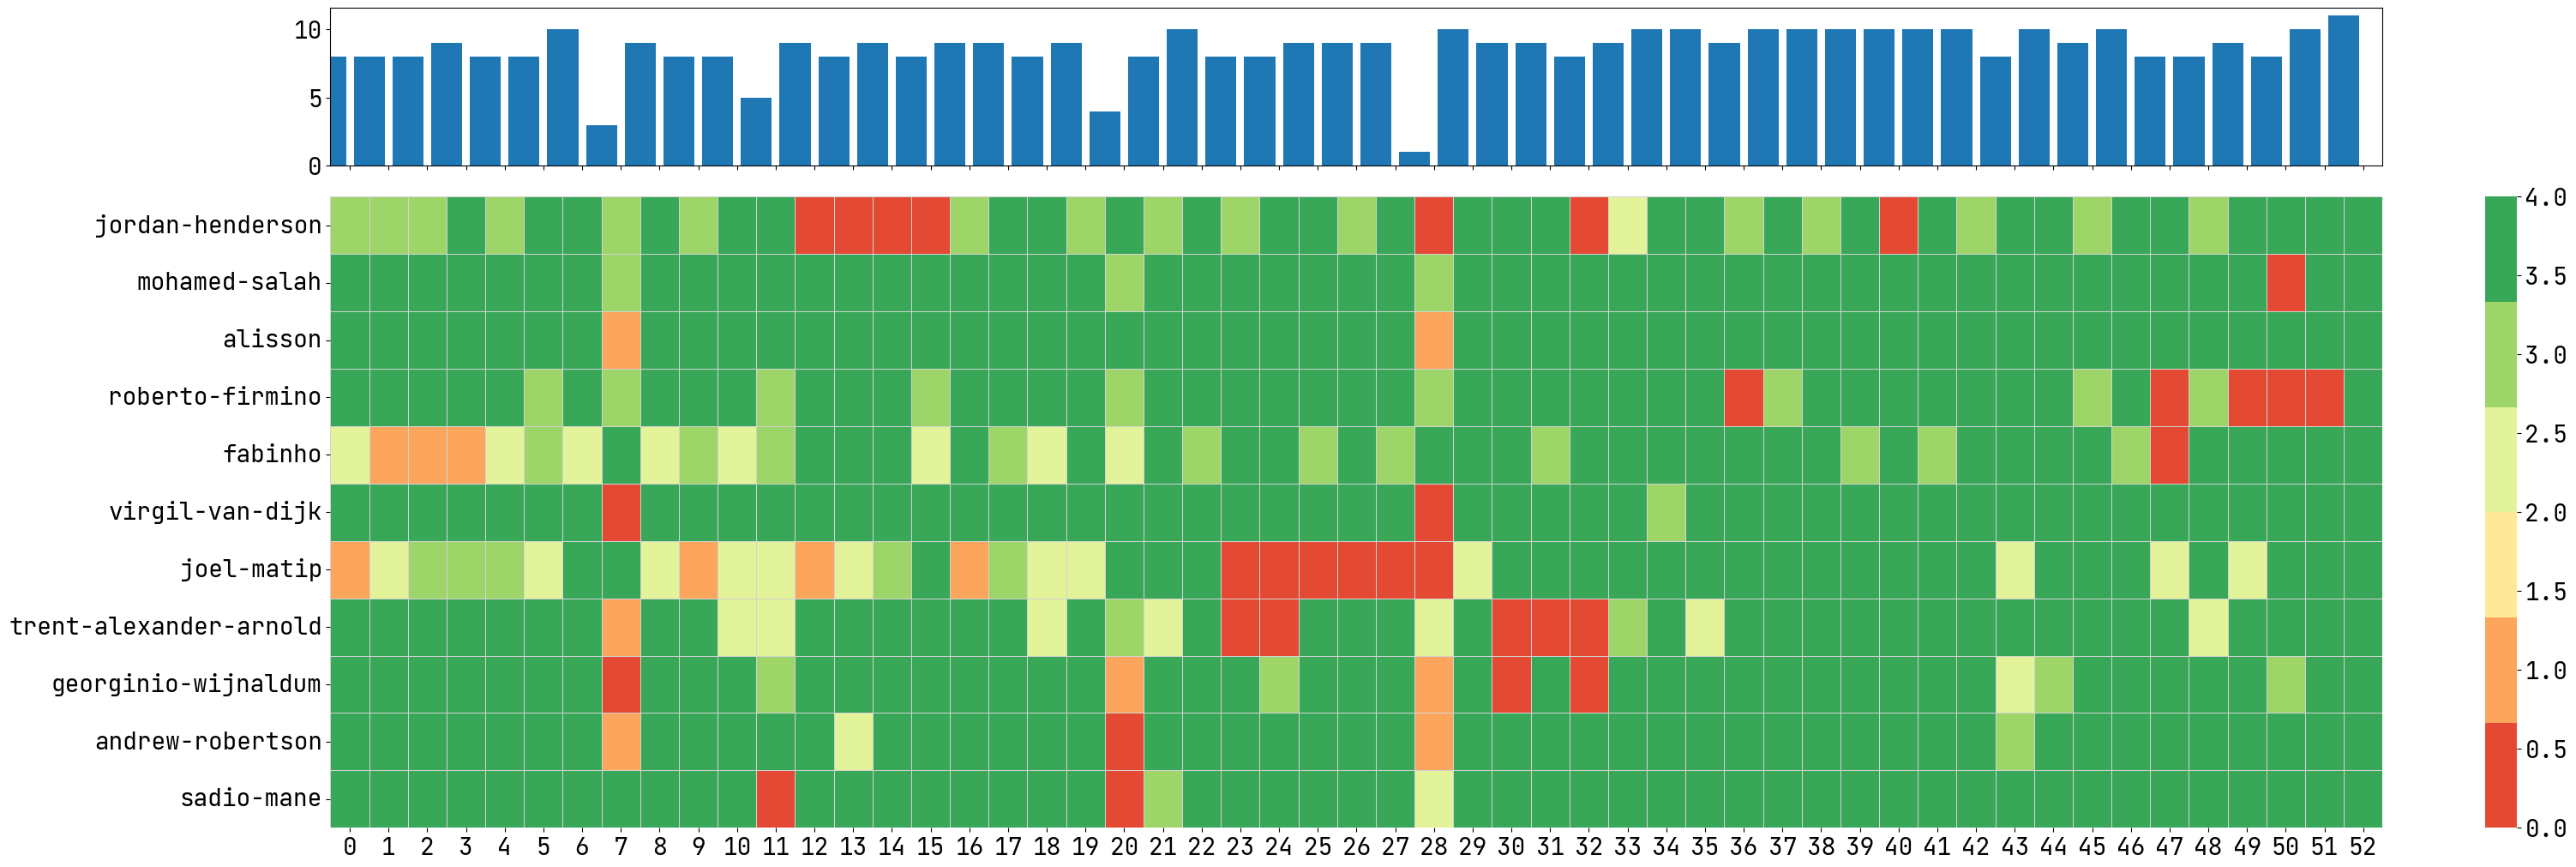

In [21]:
#| column: screen
fig,(ax1,ax2) = plt.subplots(figsize=(30,10), nrows=2, sharex=True, height_ratios=[1, 4], constrained_layout=True)

bar_plot = ax1.bar(fixtures_num_starters.index, fixtures_num_starters["strangers_count"])
plot = sns.heatmap(fixtures_num_starters.iloc[:, :-1].T, ax=ax2, cmap=sns.color_palette("RdYlGn"),linewidths=0.5, linecolor='lightgray')

Before we address the visualisation adjustments, lets grab some data for the previous season (2017/2018) so we can add some more context around the statistic:

# More Data Processing

In [22]:
liverpool_fix_17_18 = teams.get_team_fixtures(prem_clubs_18["Liverpool FC"], "2017")

In [23]:
avail_17_18 = []

for player,url in cl_19_lineup_urls.items():
    avail_df = players.get_player_availability(url,"2017", add_match_result=True)
    # add liverpool fixture data
    avail_df = avail_df.T.join(liverpool_fix_17_18, how="right", rsuffix="_lpool")
    avail_17_18.append(avail_df.T)


More data, more problems - we now need to account for when players didn't play for Liverpool - e.g. Virgil Van Dijk only join in January 2018 and was playing for Southampton during the first half of the season:

In [55]:
vvd_idx = [idx for idx, df in enumerate(avail_17_18) if 'virgil' in df.index[0]][0]

In [42]:
avail_17_18[vvd_idx].iloc[:5, :5].dropna(axis=1)

Date,2017-08-12,2017-08-19,2017-08-23
virgil-van-dijk,0,0,0
Home team.1,Southampton (11.),Southampton (11.),Southampton
Away team.1,Swansea (12.),West Ham (20.),Wolves
Result,0:0,3:2,0:2
Matchday,1,2,Qualifying Round 2nd leg


We can account for this by adding another category to our availability levels:

In [56]:
def is_liverpool(rw):
    try:
        if 'Liverpool' in rw['Home team.1'] or 'Liverpool' in rw['Away team.1']:
            return True
        else:
            return False
    except TypeError:
        return False 
vvd = avail_17_18[vvd_idx].T
vvd['is_lpool'] = vvd.apply(is_liverpool, axis=1)

def add_diff_team_availability(rw):
    """add -1 if player isn't playing a liverpool game"""
    if rw['is_lpool'] == False:
        return -1
    else:
        # availability col
        return rw[0]

vvd.iloc[:,0] = vvd.apply(add_diff_team_availability, axis=1)

This heuristic doesn't work when they play against Liverpool for their old club - but we can just fix that manually since it'll be easy to spot (one game for Liverpool surrounded by loads of games for Southampton will stick out like a sore thumb)

In [60]:
vvd.sample(5).iloc[:, :3].dropna()

,virgil-van-dijk,Home team.1,Away team.1
Date,,,
2017-11-18,4,Liverpool (5.),Southampton (13.)
2017-11-04,-1,Southampton (10.),Burnley (7.)
2017-08-12,-1,Southampton (11.),Swansea (12.)


In [61]:
#| code-fold: true
#| code-summary: Let's now grab data for the seasons before and after (17/18 and 19/20, 20/21 and 21/22)

# should have refactored the data collection/processing loop into a function

avail_17_18 = []
for player,url in cl_19_lineup_urls.items():
    avail_df = players.get_player_availability(url,"2017", add_match_result=True)
    # add liverpool fixture data
    transposed_df = avail_df.T
    transposed_df= transposed_df.join(liverpool_fix_17_18, how="right", rsuffix="_lpool")

    transposed_df['is_lpool'] = transposed_df.apply(is_liverpool, axis=1)
    transposed_df.iloc[:,0] = transposed_df.apply(add_diff_team_availability, axis=1)
    transposed_df = pd.DataFrame(transposed_df.iloc[:,0]).T
    avail_17_18.append(transposed_df)
    
avail_17_18_all = pd.concat(avail_17_18)
avail_17_18_all.fillna(3, inplace=True)

# add count
long_avail_17_18_df = avail_17_18_all.T
long_avail_17_18_df['strangers_count'] = (long_avail_17_18_df == 4 ).sum(axis=1)
long_avail_17_18_df.reset_index(inplace=True, drop=True)
#| echo: false
liverpool_fix_19_20 = teams.get_team_fixtures(prem_clubs_18["Liverpool FC"], "2019")
avail_19_20 = []
for player,url in cl_19_lineup_urls.items():
    avail_df = players.get_player_availability(url,"2019", add_match_result=True)
    # add liverpool fixture data
    transposed_df = avail_df.T
    transposed_df= transposed_df.join(liverpool_fix_19_20, how="right", rsuffix="_lpool")

    transposed_df['is_lpool'] = transposed_df.apply(is_liverpool, axis=1)
    transposed_df.iloc[:,0] = transposed_df.apply(add_diff_team_availability, axis=1)
    transposed_df = pd.DataFrame(transposed_df.iloc[:,0]).T
    avail_19_20.append(transposed_df)
    
avail_19_20_all = pd.concat(avail_19_20)
avail_19_20_all.fillna(3, inplace=True)

# add count
long_avail_19_20_df = avail_19_20_all.T
long_avail_19_20_df['strangers_count'] = (long_avail_19_20_df == 4 ).sum(axis=1)
long_avail_19_20_df.reset_index(inplace=True, drop=True)

#add 2020/2021

liverpool_fix_20_21 = teams.get_team_fixtures(prem_clubs_18["Liverpool FC"], "2020")
avail_20_21 = []
for player,url in cl_19_lineup_urls.items():
    avail_df = players.get_player_availability(url,"2020", add_match_result=True)
    # add liverpool fixture data
    transposed_df = avail_df.T
    transposed_df= transposed_df.join(liverpool_fix_20_21, how="right", rsuffix="_lpool")

    transposed_df['is_lpool'] = transposed_df.apply(is_liverpool, axis=1)
    transposed_df.iloc[:,0] = transposed_df.apply(add_diff_team_availability, axis=1)
    transposed_df = pd.DataFrame(transposed_df.iloc[:,0]).T
    avail_20_21.append(transposed_df)
    
avail_20_21_all = pd.concat(avail_20_21)
avail_20_21_all.fillna(3, inplace=True)

# add count
long_avail_20_21_df = avail_20_21_all.T
long_avail_20_21_df['strangers_count'] = (long_avail_20_21_df == 4 ).sum(axis=1)
long_avail_20_21_df.reset_index(inplace=True, drop=True)
#add 2021/2022

liverpool_fix_21_22 = teams.get_team_fixtures(prem_clubs_18["Liverpool FC"], "2021")
avail_21_22 = []
for player,url in cl_19_lineup_urls.items():
    avail_df = players.get_player_availability(url,"2021", add_match_result=True)
    # add liverpool fixture data
    transposed_df = avail_df.T
    transposed_df= transposed_df.join(liverpool_fix_21_22, how="right", rsuffix="_lpool")

    transposed_df['is_lpool'] = transposed_df.apply(is_liverpool, axis=1)
    transposed_df.iloc[:,0] = transposed_df.apply(add_diff_team_availability, axis=1)
    transposed_df = pd.DataFrame(transposed_df.iloc[:,0]).T
    avail_21_22.append(transposed_df)
    
avail_21_22_all = pd.concat(avail_21_22)
avail_21_22_all.fillna(3, inplace=True)

# add count
long_avail_21_22_df = avail_21_22_all.T
long_avail_21_22_df['strangers_count'] = (long_avail_21_22_df == 4 ).sum(axis=1)
long_avail_21_22_df.reset_index(inplace=True, drop=True)

# concatenate all our data 
all_fix_dates = [*avail_17_18_all.columns, *liverpool_fix.index,*avail_19_20_all.columns, *avail_20_21_all.columns,*avail_21_22_all.columns]
all_avail = pd.concat([long_avail_17_18_df, fixtures_num_starters, long_avail_19_20_df, long_avail_20_21_df,long_avail_21_22_df])

# reset index so we dont have to deal with dodgy dates in axes
all_avail.reset_index(inplace=True, drop=True)
all_avail['date'] = all_fix_dates
all_avail.tail()

To address some of the ugliness from the [initial visualisation](#initial-visualisation) we can make some changes in the visualisation setup (expand code and see comments):

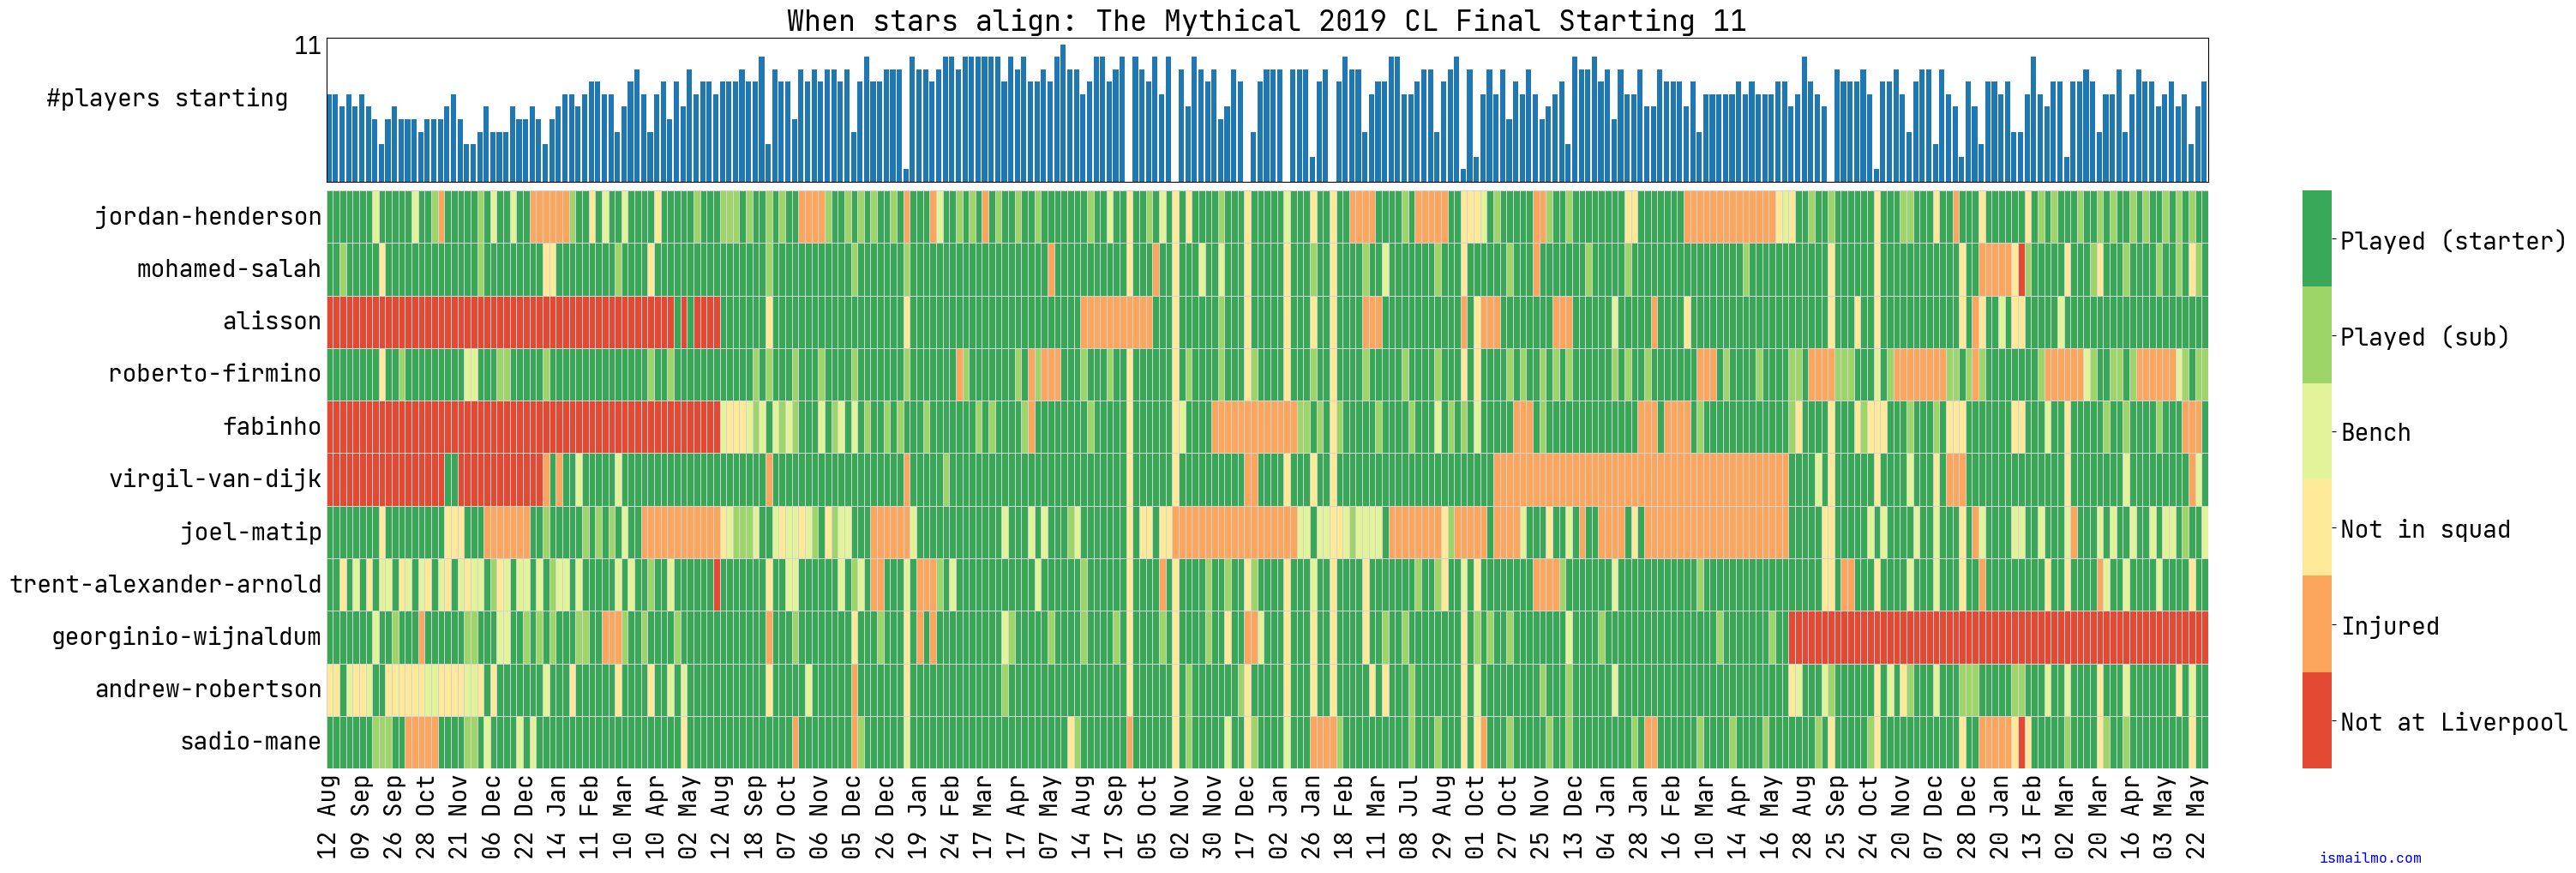

In [68]:
#| column: screen
#| code-fold: true
#| code-summary: Visualisation setup
availability_levels_map = {
                        'Not at Liverpool' : -1,
                        'Injured':0, 
                        'Not in squad':1,
                        'Bench':2, 
                        'Played (sub)':3,
                        'Played (starter)':4 
                        }
fig,(ax1,ax2) = plt.subplots(figsize=(30,10), nrows=2, sharex=True, height_ratios=[1, 4], constrained_layout=True)

# align bars to edge so its aligned with the heatmap
bar_plot = ax1.bar(all_avail.index, all_avail["strangers_count"], align="edge")
#  remove x axis label (since we share with heatmap)
_ = ax1.set_xlabel("")
_ = ax1.tick_params(length=0)
# add bar graph y label and only add tick label to max #players
_ = ax1.set_ylabel("#players starting",rotation="horizontal", ha="right" )
_ = ax1.yaxis.set_major_locator(matplotlib.ticker.FixedLocator([11]))
_ = ax1.set_title("When stars align: The Mythical 2019 CL Final Starting 11")

num_levels = len(availability_levels_map.keys())
plot = sns.heatmap(all_avail.iloc[:, :-2].T, ax=ax2, cmap=sns.color_palette("RdYlGn",num_levels),linewidths=0.5, linecolor='lightgray')

# map colorbar labels with availability levels
colorbar = plot.collections[0].colorbar
total_bar_height = colorbar.vmax - colorbar.vmin 
lvl_bar_height = total_bar_height/num_levels

colorbar.set_ticks([colorbar.vmin + (lvl_bar_height * (0.5 + i)) for i in range(num_levels)])
colorbar.set_ticklabels([*availability_levels_map.keys()])

# gotta love dates - format them so they look cleaner
axs_fmtd = [all_avail.loc[int(i.get_text()), 'date'].strftime("%d %b") for i in ax2.get_xticklabels()]
_ = ax2.set_xticklabels(axs_fmtd, rotation="vertical")
_ = ax2.set_xlabel("")
_ = ax2.tick_params(length=0)
_ = plt.gcf().text(0.9, 0, "ismailmo.com", fontsize=12, fontdict={'color':  'blue'} )

There are some anomalies where players are marked as "Not at liverpool" even though they definitely were (see Trent, Mane and salah's red lines)

Mane and Salah were playing eachother at the AFCON final - so technically the graph is correct :)

In [69]:
#| echo: false
all_avail[all_avail["sadio-mane"] == -1][["sadio-mane", 'date']]

,sadio-mane,date
258,-1.0,2022-02-06


In [70]:
#| echo: false
all_avail[all_avail["mohamed-salah"] == -1][["sadio-mane", 'date']]

,sadio-mane,date
258,-1.0,2022-02-06


For Trent, the England U21 team were playing at the same time (which Trent used to play for) so our [logic](#more-data-processing) that adjusted for games played for other clubs (e.g. Van Dijk for Southampton) picked up this game- since this is a rare edge case I'll just overwrite it manually

In [71]:
#| echo: false
url = cl_19_lineup_urls['Trent Alexander-Arnold']
avail_df = players.get_player_availability(url,"2017", add_match_result=True)
# add liverpool fixture data
transposed_df = avail_df.T
transposed_df= transposed_df.join(liverpool_fix_17_18, how="right", rsuffix="_lpool")

transposed_df['is_lpool'] = transposed_df.apply(is_liverpool, axis=1)
transposed_df.iloc[:,0] = transposed_df.apply(add_diff_team_availability, axis=1)
transposed_df = pd.DataFrame(transposed_df.iloc[:,0]).T
import datetime
avail_df.loc[:,datetime.date(2018,5,26)]

Date,2018-05-26,2018-05-26
trent-alexander-arnold,4,1
Home team.1,Real Madrid,England U21
Away team.1,Liverpool,China U20
Result,3:1,2:1


In [72]:
#| code-fold: true
#| code-summary: Manually adjusting outlier for Trent
trent_outlier = all_avail['date']==datetime.datetime(2018,5,26)
all_avail.loc[trent_outlier,"trent-alexander-arnold"] = 4

The visualisation above shows that the full squad were only playing for Liverpool FC during 2018/19 - 2021-22 (see the blocks of red at the start and end of the heatmap) - we can remove the other seasons (we'll keep a few rows to highlight their departure/arrival at Liverpool).

Another key change is choosing a better colours palette - [ColorBrewer](https://colorbrewer2.org/) is a great resource for finding accessible color schemes based on the research of [Dr Cynthia Brewer](http://www.personal.psu.edu/cab38/)

In [75]:
#| code-fold: true
#| code-summary: Narrowing down the date range

cl_19_lineup_at_lpool_avail_df = all_avail[(all_avail.loc[:,'date']>datetime.datetime(2018,5,10)) &( all_avail.loc[:,'date']<datetime.datetime(2021,8,30))]
cl_19_lineup_at_lpool_avail_df.reset_index(inplace=True, drop=True)

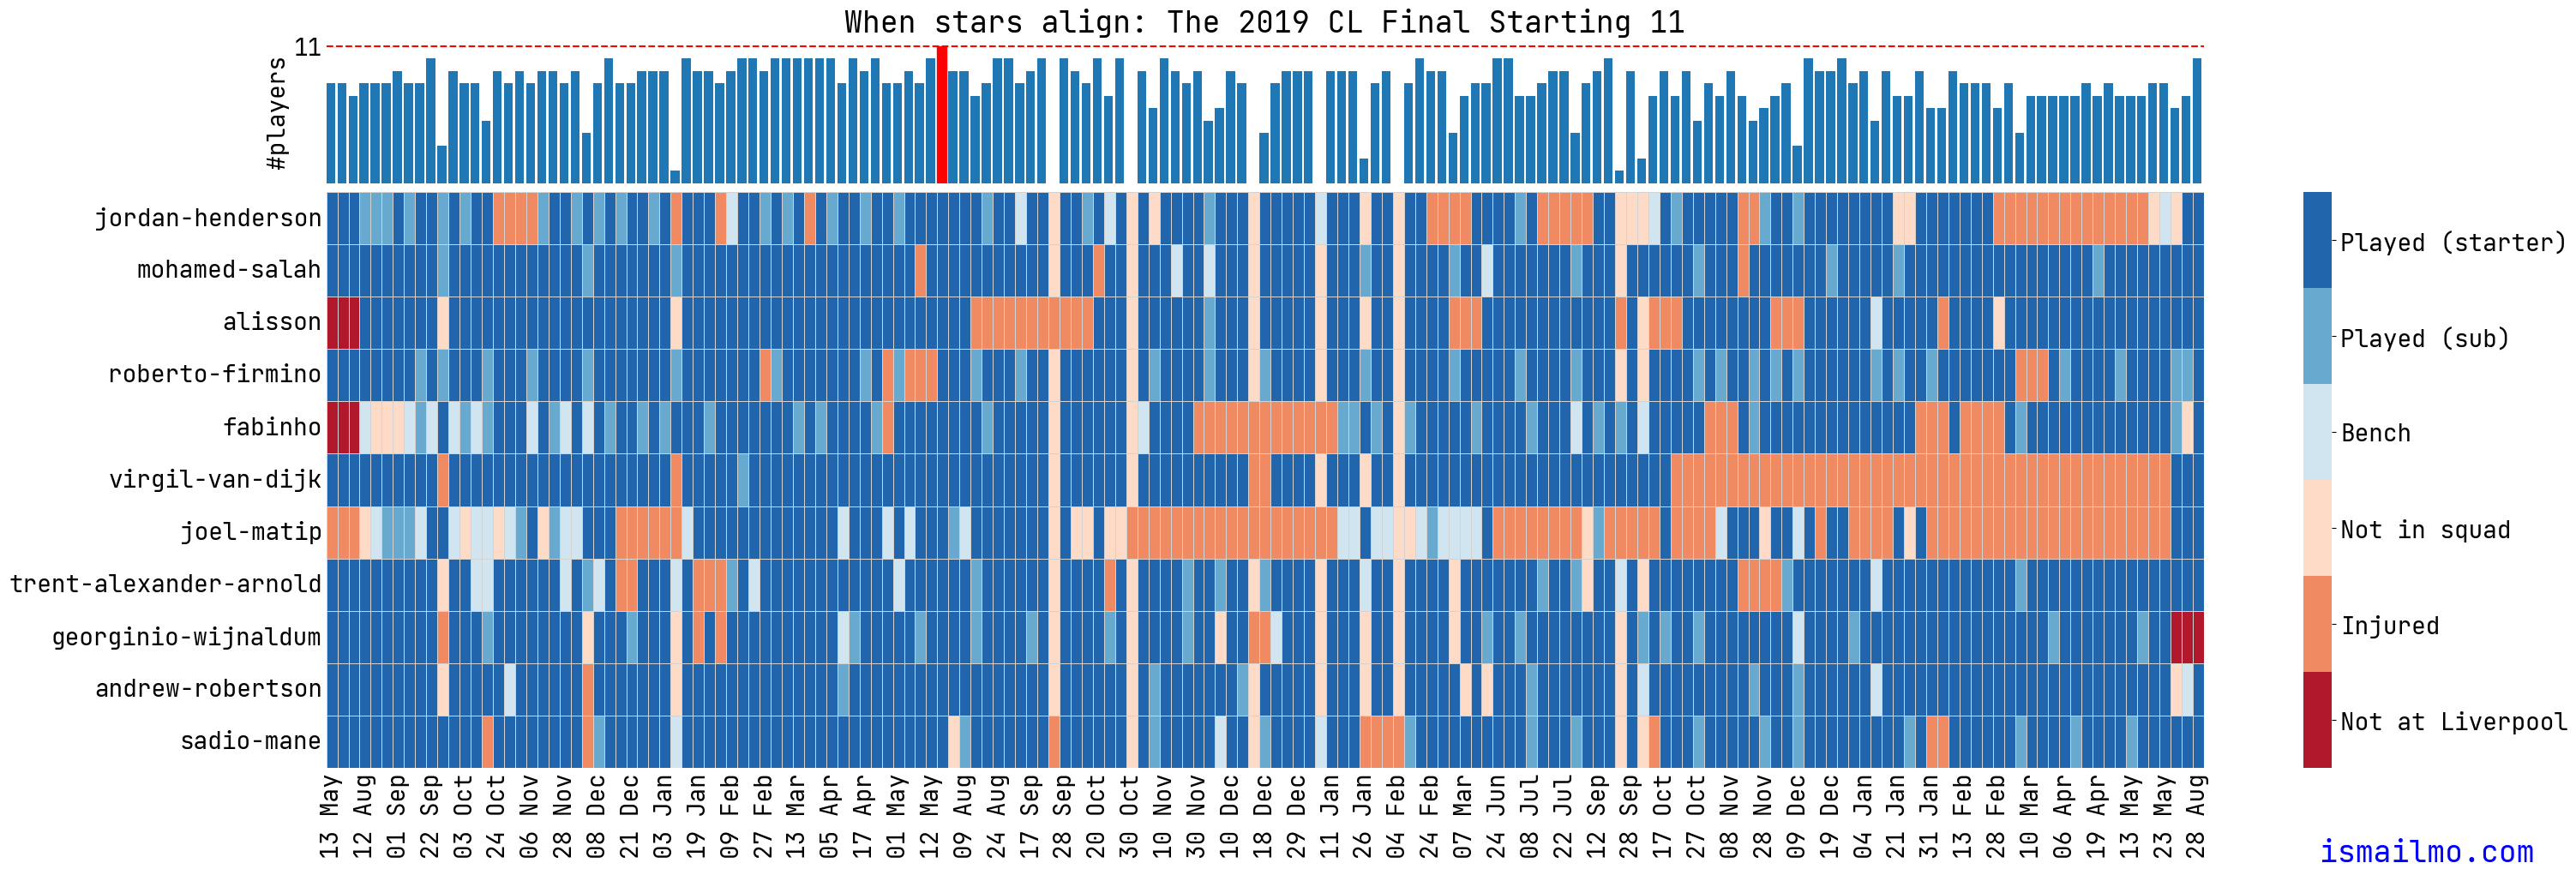

In [77]:
#| code-fold: true
#| code-summary: Final visualisation setup
#| output: false

matplotlib.rcParams['font.size'] = '20'
plt.rcParams["axes.titlesize"] ="10" 
color_scheme = ['#b2182b','#ef8a62','#fddbc7','#d1e5f0','#67a9cf','#2166ac']
alt_color_scheme = ['#762a83','#af8dc3','#e7d4e8','#d9f0d3','#7fbf7b','#1b7837']

availability_levels_map = {
                        'Not at Liverpool' : -1,
                        'Injured':0, 
                        'Not in squad':1,
                        'Bench':2, 
                        'Played (sub)':3,
                        'Played (starter)':4 
                        }
fig,(ax1,ax2) = plt.subplots(figsize=(30,10), nrows=2, sharex=True, height_ratios=[1, 4], constrained_layout=True)

bar_plot = ax1.bar(cl_19_lineup_at_lpool_avail_df.index, cl_19_lineup_at_lpool_avail_df["strangers_count"], align="edge")

# highlight champions lg final game
for i,bar in enumerate(bar_plot):
    if cl_19_lineup_at_lpool_avail_df["strangers_count"][i] ==11:
        bar.set_color("r")

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# add horizontal line at 11 players
ax1.axhline(y=11, color='r', ls='--')

_ = ax1.set_title("When stars align: The 2019 CL Final Starting 11", fontdict={"fontsize":"25"} )
_ = ax1.set_xlabel("")
_ = ax1.set_ylabel("#players",rotation="vertical", ha="center")
_ = ax1.yaxis.set_major_locator(matplotlib.ticker.FixedLocator([11]))
_ = ax1.tick_params(length=0)

num_levels = len(availability_levels_map.keys())
plot = sns.heatmap(cl_19_lineup_at_lpool_avail_df.iloc[:, :-2].T, ax=ax2, cmap=color_scheme,linewidths=0.5, linecolor='lightgray')
colorbar = plot.collections[0].colorbar
total_bar_height = colorbar.vmax - colorbar.vmin 
lvl_bar_height = total_bar_height/num_levels


colorbar.set_ticks([colorbar.vmin + (lvl_bar_height * (0.5 + i)) for i in range(num_levels)])
colorbar.set_ticklabels([*availability_levels_map.keys()])

axs_fmtd = [cl_19_lineup_at_lpool_avail_df.loc[int(i.get_text()), 'date'].strftime("%d %b") for i in ax2.get_xticklabels()]
_ = ax2.set_xticklabels(axs_fmtd, rotation="vertical")
_ = ax2.set_xlabel("")
_ = ax2.tick_params(length=0)
_ = plt.gcf().text(0.9, 0, "ismailmo.com", fontsize=25, fontdict={'color':  'blue'} )

# Final Visualisation

The final visualisation is complete, but to add some extra context I added annotations using [Excalidraw](excalidraw.com) to highlight some key points (probably could've done this in code but I got lazy):

::: {.column-screen}

![Annotated heatmap](annotated_heatmap.png)
:::